In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml #found this method to load openml datasets from https://scikit-learn.org/stable/datasets/loading_other_datasets.html
import warnings
warnings.filterwarnings("ignore") #this is so that output is executed smoothly https://www.geeksforgeeks.org/how-to-disable-python-warnings/

# loaded each of the datasets by id instead of name, for version control reasons 
steel_plates_fault = fetch_openml(data_id=1504)
ionosphere = fetch_openml(data_id=59)
banknotes = fetch_openml(data_id=1462)

# preparing each dataset by loading its data as well as its target 
datasets = {
    "Steel Plates Fault": (steel_plates_fault.data, steel_plates_fault.target),
    "Ionosphere": (ionosphere.data, ionosphere.target),
    "Banknotes": (banknotes.data, banknotes.target)
}


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# definining each classifier, the hyperparameter name and the values that were given in table i within the assignment 1 pdf
classifiers = {
    "KNeighborsClassifier": (KNeighborsClassifier, "n_neighbors", [1, 2, 3, 4, 5]),
    "GaussianNB": (GaussianNB, "var_smoothing", [1e-9, 1e-5, 1e-1]),
    "LogisticRegression": (LogisticRegression, "C", [0.1, 0.5, 1.0, 2.0, 5.0]),
    "DecisionTreeClassifier": (DecisionTreeClassifier, "max_depth", [1, 3, 5, 8, 10]),
    "GradientBoostingClassifier": (GradientBoostingClassifier, "max_depth", [1, 3, 5, 8, 10]),
    "RandomForestClassifier": (RandomForestClassifier, "max_depth", [1, 3, 5, 8, 10]),
    "MLPClassifier": (MLPClassifier, "alpha", [1e-5, 1e-3, 0.1, 10.0])
}


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# creating a dictionary to store results. keys, items and much of my code was learnt and adapted from this website: https://www.w3schools.com/  
results = {clf_name: {ds_name: [] for ds_name in datasets.keys()} for clf_name in classifiers.keys()}

# executing the classification
for clf_name, (clf_class, param_name, param_values) in classifiers.items():
    for ds_name, (X, y) in datasets.items():
        accuracies = {param_value: [] for param_value in param_values}
        
        for i in range(50):
            # splitting the data 50:50 into train and test sets 
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i)
            
            for param_value in param_values:
                # connecting each classifier with its specific hyperparameter
                clf = clf_class(**{param_name: param_value})
                
                # training each classifier
                clf.fit(X_train, y_train)
                
                # predicting test data
                y_pred = clf.predict(X_test)
                
                # getting accuracy scores
                accuracy = accuracy_score(y_test, y_pred)
                accuracies[param_value].append(accuracy)
        
        # storing the results 
        results[clf_name][ds_name] = accuracies


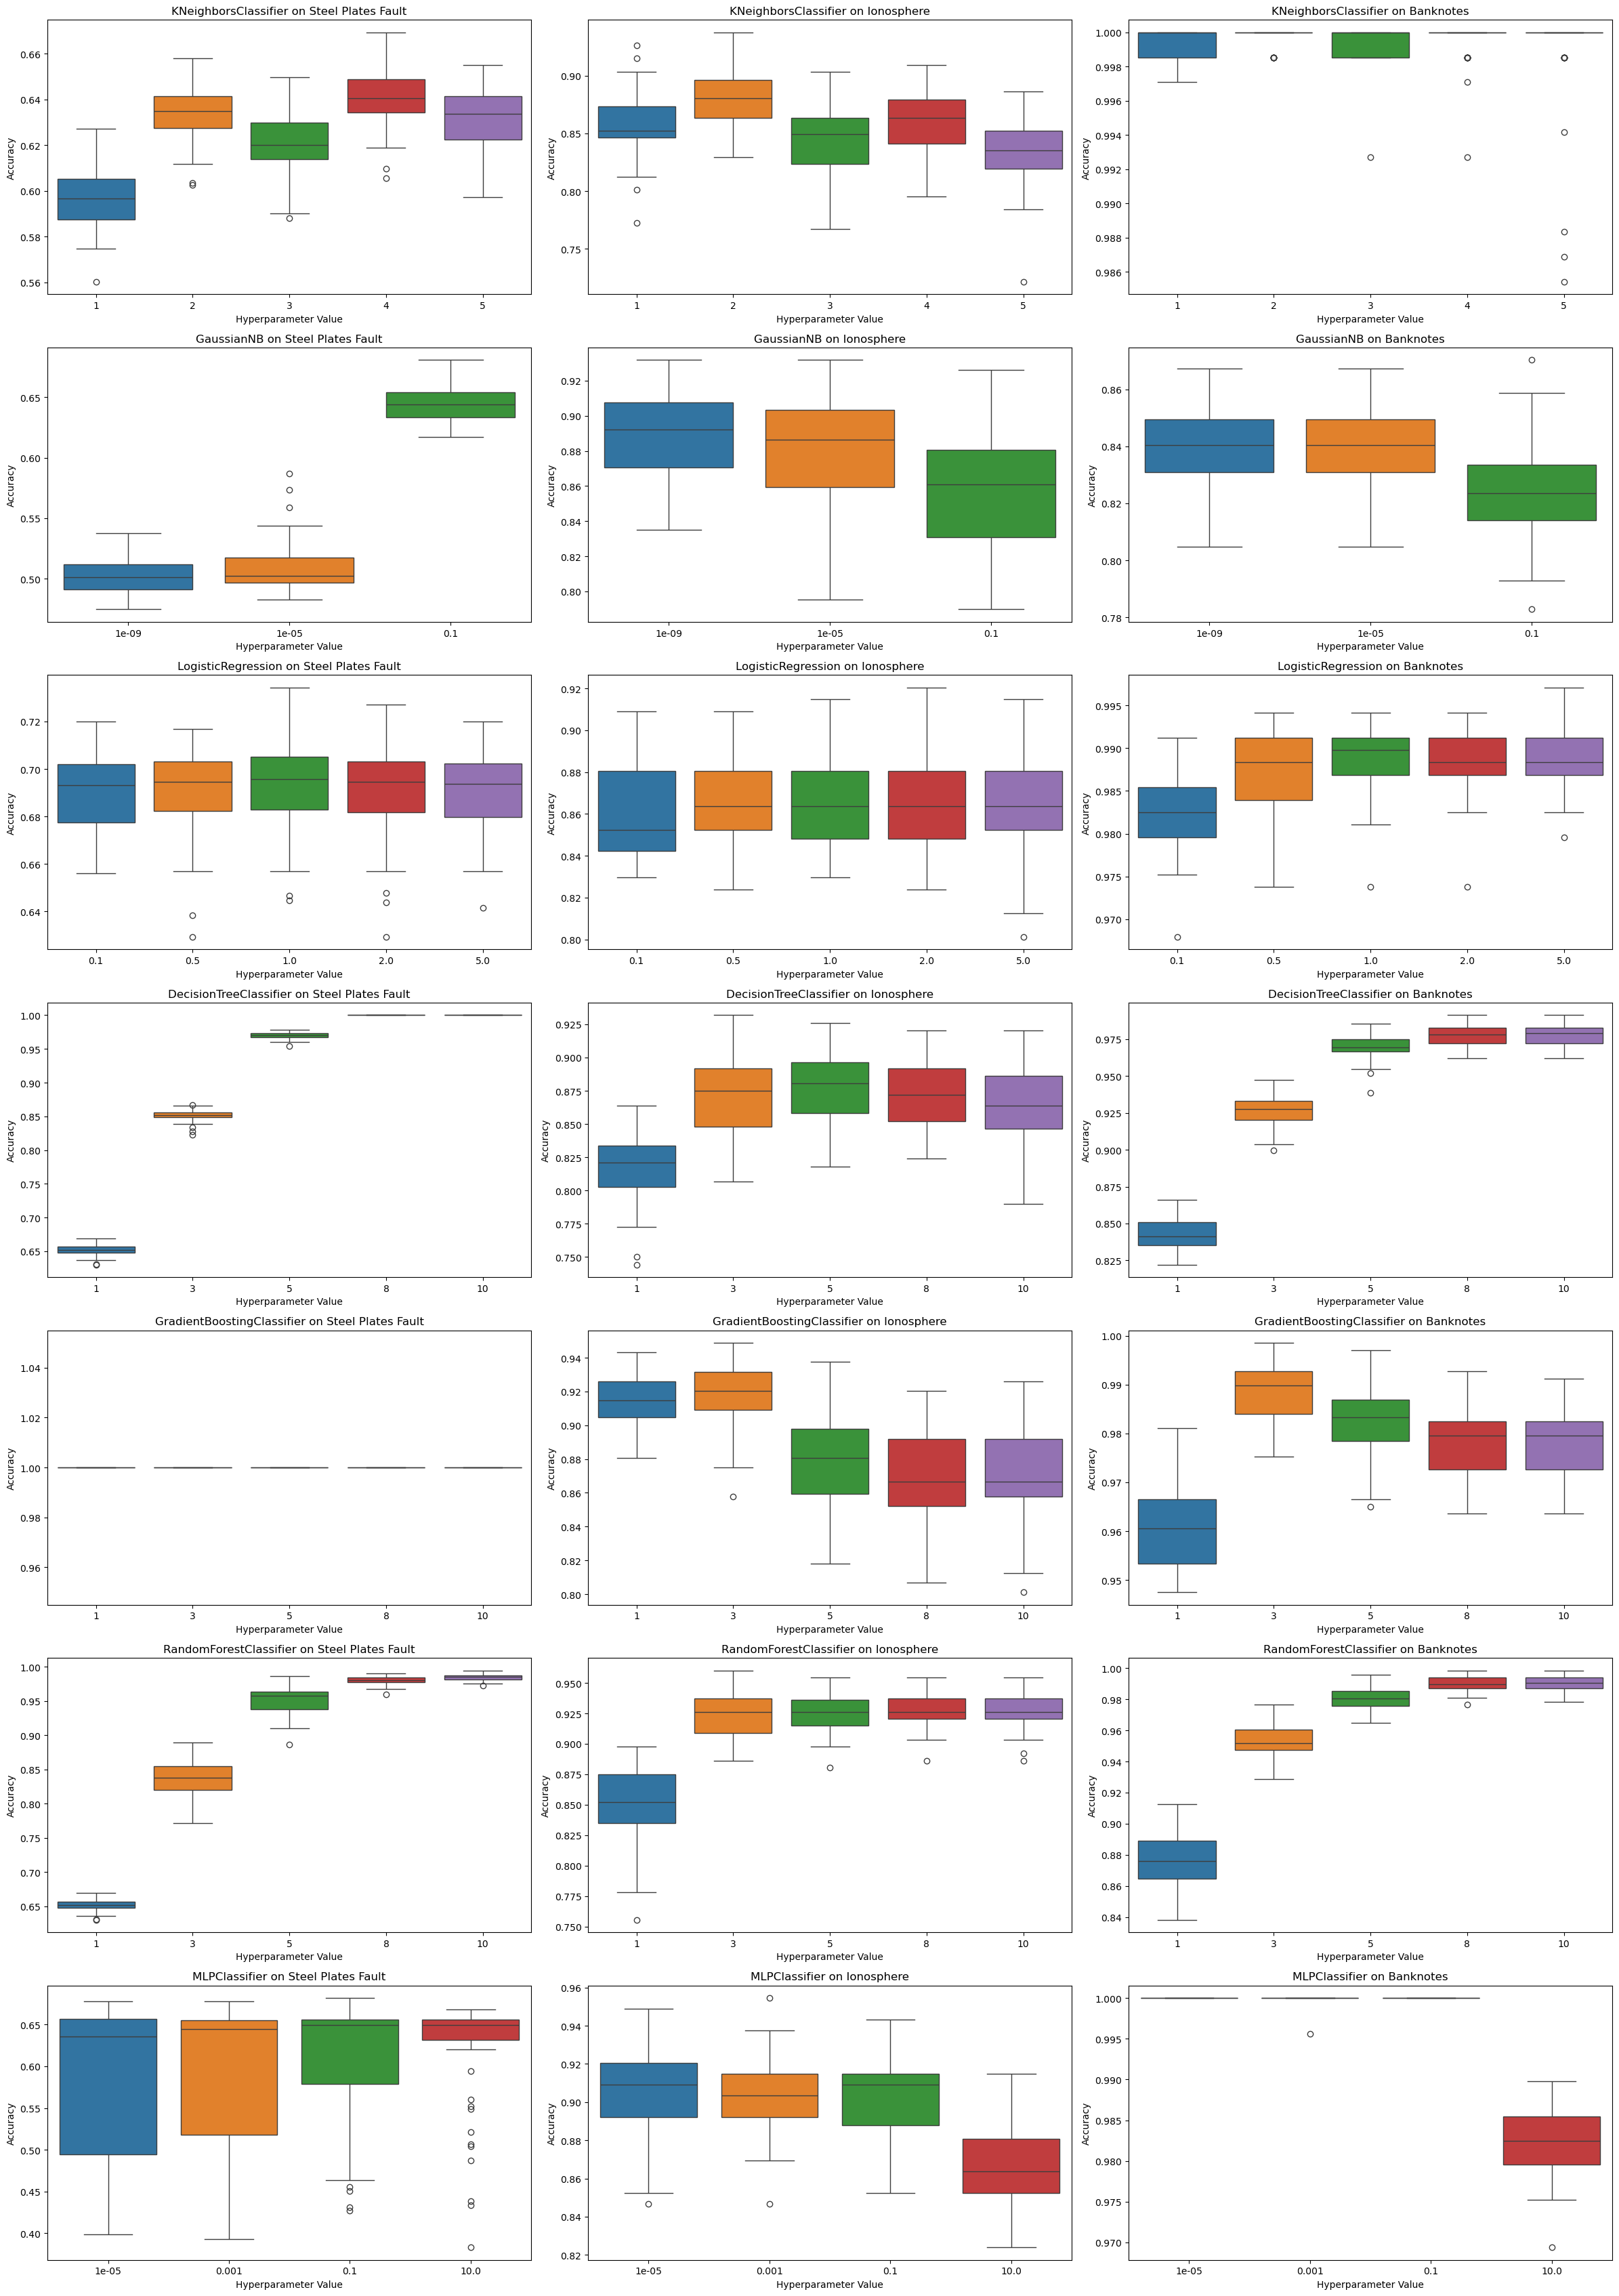

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

#setting up the boxplots in a 7 by 3 format
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(24, 34))


for clf_idx, (clf_name, clf_results) in enumerate(results.items()):
    for ds_idx, (ds_name, ds_accuracies) in enumerate(clf_results.items()):
        ax = axes[clf_idx, ds_idx]
        sns.boxplot(data=pd.DataFrame(ds_accuracies), ax=ax)
        ax.set_title(f'{clf_name} on {ds_name}')
        ax.set_xlabel('Hyperparameter Value')
        ax.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [32]:
# creating summary tables
mean_errors = {clf_name: {ds_name: None for ds_name in datasets.keys()} for clf_name in classifiers.keys()}
best_params = {clf_name: {ds_name: None for ds_name in datasets.keys()} for clf_name in classifiers.keys()}

for clf_name, clf_results in results.items():
    for ds_name, ds_accuracies in clf_results.items():
        mean_accuracies = {param_value: np.mean(acc) for param_value, acc in ds_accuracies.items()}
        best_param_value = max(mean_accuracies, key=mean_accuracies.get)
        best_mean_accuracy = mean_accuracies[best_param_value]
        
        # storing best results
        mean_errors[clf_name][ds_name] = 1 - best_mean_accuracy
        best_params[clf_name][ds_name] = best_param_value

# converting dictionaries to a dataframe
mean_errors_df = pd.DataFrame(mean_errors)
best_params_df = pd.DataFrame(best_params)


In [34]:
mean_errors_df.head()

,KNeighborsClassifier,GaussianNB,LogisticRegression,DecisionTreeClassifier,GradientBoostingClassifier,RandomForestClassifier,MLPClassifier
Steel Plates Fault,0.359918,0.355201,0.306962,0.000000,0.000000,0.015283,0.381607
Ionosphere,0.118636,0.111591,0.133523,0.124773,0.082045,0.071818,0.096136
Banknotes,0.000204,0.159971,0.010991,0.022478,0.011079,0.009650,0.000000


In [36]:
best_params_df.head()

,KNeighborsClassifier,GaussianNB,LogisticRegression,DecisionTreeClassifier,GradientBoostingClassifier,RandomForestClassifier,MLPClassifier
Steel Plates Fault,4,1.000000e-01,1.0,8,1,10,10.00000
Ionosphere,2,1.000000e-09,2.0,5,3,8,0.10000
Banknotes,2,1.000000e-09,1.0,10,3,8,0.00001


Question 2

In [42]:
from sklearn.datasets import make_blobs, make_classification, make_circles
from sklearn.preprocessing import StandardScaler

# setting seed for reproducibility
seed = 42

# generating toy datasets
X_blobs, _ = make_blobs(n_samples=1000, n_features=2, random_state=seed)
X_classification, _ = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1,
    random_state=seed
)
X_circles, _ = make_circles(n_samples=1000, noise=0.3, random_state=seed)

# using standard scaler on the data for better clustering 
scaler = StandardScaler()
X_blobs = scaler.fit_transform(X_blobs)
X_classification = scaler.fit_transform(X_classification)
X_circles = scaler.fit_transform(X_circles)

(X_blobs.shape, X_classification.shape, X_circles.shape)



((1000, 2), (1000, 2), (1000, 2))

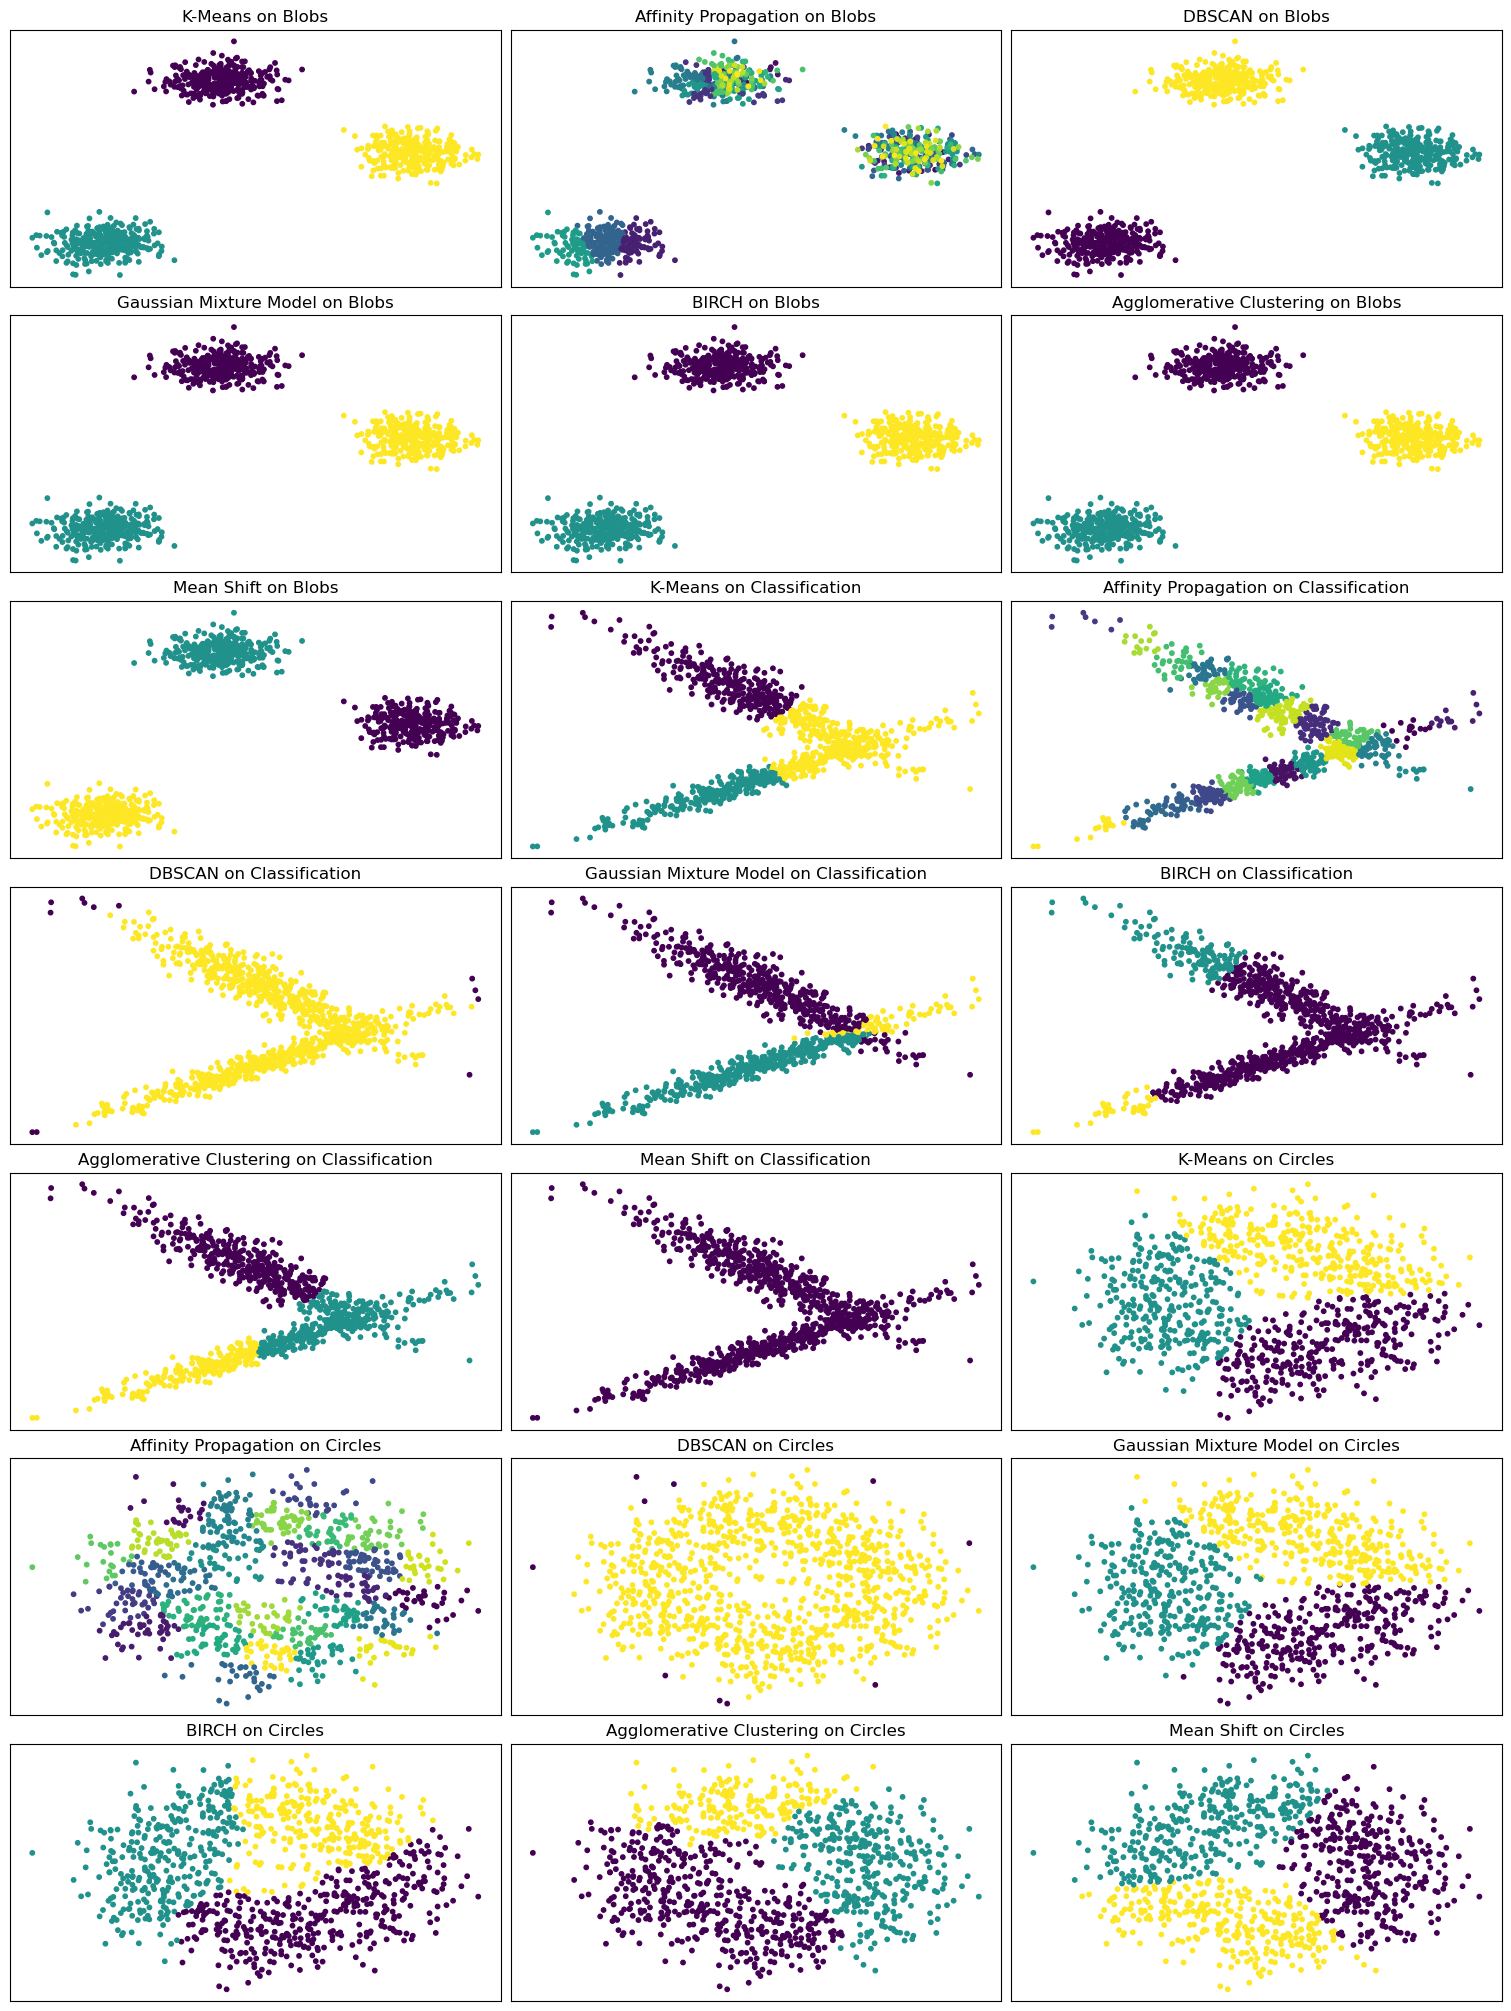

In [48]:
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN, Birch, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture


# defining the clustering models
clustering_algorithms = {
    "K-Means": KMeans(n_clusters=3, random_state=seed),
    "Affinity Propagation": AffinityPropagation(random_state=seed),
    "DBSCAN": DBSCAN(eps=0.3),
    "Gaussian Mixture Model": GaussianMixture(n_components=3, random_state=seed),
    "BIRCH": Birch(n_clusters=3),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=3),
    "Mean Shift": MeanShift()
}

# preparing data
datasets = {
    "Blobs": X_blobs,
    "Classification": X_classification,
    "Circles": X_circles
}

# plotting
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()

plot_idx = 0

# iterating over each dataset and algorithm
for data_name, X in datasets.items():
    for algo_name, model in clustering_algorithms.items():
        # using fit_predict for models that do not support separate fit and predict
        if algo_name in ["DBSCAN", "Affinity Propagation", "Agglomerative Clustering", "Gaussian Mixture Model"]:
            if algo_name == "Affinity Propagation":
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=UserWarning)
                    clusters = model.fit_predict(X)
            else:
                clusters = model.fit_predict(X)
        else:
            clusters = model.fit(X).predict(X)
        
        # plotting results
        axes[plot_idx].scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=10)
        axes[plot_idx].set_title(f"{algo_name} on {data_name}")
        axes[plot_idx].set_xticks([])
        axes[plot_idx].set_yticks([])
        
        plot_idx += 1
plt.show()


In [ ]:
# References of key scikit learn pages used on top of course notes.
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html

Statement on Use of AI tools: During this assignment I used ChatGPT to help me troubleshoot my python code errors and to improve my academic writing in the report. 